In [2]:
import numpy as np
import time
import torch

def ProjectOntoL1Ball(v, b):
    """Projects vector v onto the L1 ball with radius b."""
    if b < 0:
        raise ValueError(f"Radius of L1 ball is negative: {b:.3f}")
    if np.linalg.norm(v, ord=1) <= b:
        return v.copy()
    u = np.sort(np.abs(v))[::-1]  # Descending order
    sv = np.cumsum(u)
    rho = np.where(u > (sv - b) / np.arange(1, len(u) + 1))[0]
    if rho.size == 0:
        theta = 0.0
    else:
        rho_idx = rho[-1]
        theta = (sv[rho_idx] - b) / (rho_idx + 1)
    w = np.sign(v) * np.maximum(np.abs(v) - theta, 0)
    return w

def DBGD(fun_f, grad_f, grad_g, fun_g, TSA, param, x0, a):
    """Dynamic Barrier Gradient Descent algorithm."""
    stepsize = param['stepsize']
    alpha = param['alpha']
    beta = param['beta']
    lambda_ = param['lam']  # Avoid 'lambda' keyword
    maxiter = param['maxiter']
    maxtime = param['maxtime']
    # a = a
    x = x0.copy()
    start_time = time.time()
    iter_count = 0
    f_vec1, g_vec1, time_vec1, acc_vec = [], [], [], []
    d_vec = []
    grad_g_norm_vec = []
    weight_vec = []
    x_vec = []
    while iter_count <= maxiter:
        # x_prev = x
        iter_count += 1
        # stepsize = stepsize / (a+iter_count ** (1/3))
        x_vec.append(x)
        grad_f_x = grad_f(x)
        grad_g_x = grad_g(x)
        grad_g_norm_vec.append(np.linalg.norm(grad_g_x)**2)
        # Compute phi and weight (lambda_k)
        g_x = fun_g(x)
        grad_g_sq = np.dot(grad_g_x, grad_g_x)
        phi = grad_g_sq
        
        denominator = grad_g_sq
        if denominator == 0:
            weight = 0.0
        else:
            numerator = phi - np.dot(grad_f_x, grad_g_x)
            weight = max(numerator / denominator, 0.0)
        weight_vec.append(weight)
        v = grad_f_x + weight * grad_g_x
        x = x - stepsize * v
        d_vec.append(np.linalg.norm(v)**2)
        # Projection onto L1 ball
        # x = ProjectOntoL1Ball(x, lambda_)
        
        # Record metrics
        elapsed = time.time() - start_time
        f_vec1.append(fun_f(x))
        g_vec1.append(fun_g(x))
        # time_vec1.append(elapsed)
        time_vec1.append(iter_count)
        acc_vec.append(TSA(x))
        
        # Log progress
        if iter_count % 50000 == 0:
            print(f"Iteration: {iter_count}")
        
        # Check time constraint
        # if elapsed > maxtime:
        #     break
        
        # iter_count += 1
    
    # Convert lists to numpy arrays
    return (
        np.array(f_vec1),
        np.array(g_vec1),
        np.array(time_vec1),
        x,
        np.array(acc_vec),
        np.array(d_vec),
        np.array(grad_g_norm_vec),
        np.array(weight_vec),
        np.array(x_vec)
    )

f_type = 'type3'
# center = np.random.randn(10)
# center = np.array([-0.17123975, 0.41076865, 0.00638485, 0.06888395])
# center = np.random.randn(2)
# center = np.array([1.70361,-0.796084]) # local min
# center = np.array([3,2])
center = np.array([0.0898,-0.7126]) # global min

if f_type == 'type1':
    def example_f(x):
        return (x[0] - 1)**2 + (x[1] + 10)**2

    def example_grad_f(x):
        return np.array([2*(x[0] - 1), 2*(x[1] + 10)])
    
if f_type == 'type2':
    def example_f(x):
        return (x[0])**2 + (x[1])**2

    def example_grad_f(x):
        return np.array([2*x[0], 2*x[1]])   

if f_type == 'type3':
    def example_f(x):
        """Sphere function in arbitrary dimensions centered at 'center'"""
        return np.sum((x - center[:len(x)])**2)

    def example_grad_f(x):
        """Gradient of sphere function in arbitrary dimensions"""
        return 2 * (x - center[:len(x)])

if f_type == 'type4':
    def example_f(x):
        """Function evaluation using numpy"""
        # Split input into x and y components
        term1 = np.cos(4*x[1] + 2) / (1 + np.exp(2 - 4*x[0]))
        term2 = 0.5 * np.log((4*x[0] - 2)**2 + 1)
        return term1 + term2

    def example_grad_f(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        term1 = torch.cos(4*x_torch[1] + 2) / (1 + torch.exp(2 - 4*x_torch[0]))
        term2 = 0.5 * torch.log((4*x_torch[0] - 2)**2 + 1)
        y = term1 + term2
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if f_type == 'type5':
    def example_f(x):
        """Function: (sin(y) - x)^2
        where x = x[0] and y = x[1]"""
        return (np.sin(x[1]) - x[0])**2

    def example_grad_f(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        z = (torch.sin(x_torch[1]) - x_torch[0])**2
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

# Example test functions
# def example_f(x):
#     return (x[0] - 1)**2 + (x[1] + 10)**2

# def example_grad_f(x):
#     return np.array([2*(x[0] - 1), 2*(x[1] + 10)])

g_type = '6hump'

if g_type == 'type1':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Add clipping to prevent overflow
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(1 - r / np.pi)
        return -abs(np.sin(x[0]) * np.cos(x[1]) * exp_term)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2)
        exp_term = torch.exp(torch.clamp(1 - r / np.pi, min=-100, max=100))
        y = -torch.abs(torch.sin(x_torch[0]) * torch.cos(x_torch[1]) * exp_term)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)):
            print(f"Warning: NaN gradient detected at x={x}")
            # Return zero gradient instead of NaN
            return np.zeros_like(x)
        
        return grad
if g_type == 'type2':
    def example_g(x):
        return (x[1] - np.sin(x[0]))**2

    def example_grad_g(x):
        return np.array([
            -2 * np.cos(x[0]) * (x[1] - np.sin(x[0])),
            2 * (x[1] - np.sin(x[0]))
        ])
    
if g_type == 'type3':
    def example_g(x):
        return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

    def example_grad_g(x):
        # Gradient of g with respect to x[0] and x[1]
        dx = 2*(x[0]**2 + x[1] - 11)*(2*x[0]) + 2*(x[0] + x[1]**2 - 7)
        dy = 2*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)*(2*x[1])
        return np.array([dx, dy])
    
if g_type == 'type4':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        r = np.sqrt(x[0]**2 + x[1]**2)
        exp_term = np.exp(100 - r / np.pi)
        inner_term = abs(np.sin(x[0]) * np.sin(x[1]) * exp_term) + 1
        return -0.0001 * (inner_term ** 0.1)

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations with more stable computation
        r = torch.sqrt(x_torch[0]**2 + x_torch[1]**2 + 1e-8)  # Add small epsilon for stability
        exp_term = torch.exp(torch.clamp(100 - r / np.pi, min=-50, max=50))  # Clamp exponential
        sin_term = torch.sin(x_torch[0]) * torch.sin(x_torch[1])
        inner_term = torch.abs(sin_term * exp_term) + 1
        y = -0.0001 * (inner_term ** 0.1)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            # Instead of returning zeros, return a small gradient in the direction of x
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'type5':
    def example_g(x):
        """The complex function using numpy for regular evaluation"""
        # Compute intermediate terms
        x_sq_minus_y_sq = x[0]**2 - x[1]**2
        squared_norm = x[0]**2 + x[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        return 0.5 + (np.cos(np.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute intermediate terms
        x_sq_minus_y_sq = x_torch[0]**2 - x_torch[1]**2
        squared_norm = x_torch[0]**2 + x_torch[1]**2
        denominator = (1 + 0.001 * squared_norm)**2
        
        # Compute the full function
        y = 0.5 + (torch.cos(torch.sin(x_sq_minus_y_sq))**2 - 0.5) / denominator
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'type6':
    def example_g(x):
        """Circle function: (x^2 + y^2 - 1)^2
        Global minimum of 0 occurs on the unit circle x^2 + y^2 = 1"""
        return (x[0]**2 + x[1]**2 - 1)**2

    def example_grad_g(x):
        """Gradient computation for circle function using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        z = (x_torch[0]**2 + x_torch[1]**2 - 1)**2
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'type7':
    def example_g(x):
        """Function: (y - sin(x))^2
        where x = x[0] and y = x[1]"""
        return (x[1] - np.sin(x[0]))**2

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        z = (x_torch[1] - torch.sin(x_torch[0]))**2
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'type8':
    def example_g(x):
        """Function: x^2 + y^4
        where x = x[0] and y = x[1]"""
        return x[0]**2 + x[1]**4

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        z = x_torch[0]**2 + x_torch[1]**4
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
if g_type == 'type9':
    def example_g(x):
        """Function: x^4 + 10(y-x^2)^2
        where x = x[0] and y = x[1]"""
        return x[0]**4 + 10*(x[1] - x[0]**2)**2

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        z = x_torch[0]**4 + 10*(x_torch[1] - x_torch[0]**2)**2
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
if g_type == 'type10':
    def example_g(x):
        """N-dimensional function: x₁⁴ + 10∑(i=2..n)(xᵢ - x₁²)²
        Input x can be any dimension >= 2"""
        n = len(x)
        if n < 2:
            raise ValueError("Function requires dimension >= 2")
        
        term1 = x[0]**4  # x₁⁴
        sum_terms = sum(10 * (x[i] - x[0]**2)**2 for i in range(1, n))  # 10∑(xᵢ - x₁²)²
        return term1 + sum_terms

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        n = len(x)
        if n < 2:
            raise ValueError("Function requires dimension >= 2")
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute function using PyTorch operations
        term1 = x_torch[0]**4
        sum_terms = sum(10 * (x_torch[i] - x_torch[0]**2)**2 for i in range(1, n))
        z = term1 + sum_terms
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

   
if g_type == 'rosenbrock2d':
    def example_g(x):
        """2D Rosenbrock function using numpy"""
        return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

    def example_grad_g(x):
        """Gradient computation for 2D Rosenbrock using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the Rosenbrock function
        y = 100 * (x_torch[1] - x_torch[0]**2)**2 + (1 - x_torch[0])**2
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad
    
if g_type == 'rosenbrock3d':
    def example_g(x):
        """3D Rosenbrock function using numpy"""
        return (100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2 + 
                100 * (x[2] - x[1]**2)**2 + (1 - x[1])**2)

    def example_grad_g(x):
        """Gradient computation for 3D Rosenbrock using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the 3D Rosenbrock function
        y = (100 * (x_torch[1] - x_torch[0]**2)**2 + (1 - x_torch[0])**2 + 
            100 * (x_torch[2] - x_torch[1]**2)**2 + (1 - x_torch[1])**2)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'rosenbrock':
    def example_g(x):
        """N-dimensional Rosenbrock function using numpy
        Input x can be any dimension >= 2"""
        n = len(x)
        if n < 2:
            raise ValueError("Rosenbrock function requires dimension >= 2")
        
        terms = []
        for i in range(n-1):
            terms.append(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2)
        
        return np.sum(terms)

    def example_grad_g(x):
        """Gradient computation for N-dimensional Rosenbrock using PyTorch autograd"""
        n = len(x)
        if n < 2:
            raise ValueError("Rosenbrock function requires dimension >= 2")
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the N-dimensional Rosenbrock function
        terms = []
        for i in range(n-1):
            terms.append(100 * (x_torch[i+1] - x_torch[i]**2)**2 + (1 - x_torch[i])**2)
        y = sum(terms)
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'ackley':
    def example_g(x):
        """Ackley function using numpy"""
        term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2)))
        term2 = -np.exp(0.5 * (np.cos(2*np.pi*x[0]) + np.cos(2*np.pi*x[1])))
        return term1 + term2 + np.e + 20

    def example_grad_g(x):
        """Gradient computation for Ackley function using PyTorch autograd"""
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Compute the Ackley function
        term1 = -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x_torch[0]**2 + x_torch[1]**2)))
        term2 = -torch.exp(0.5 * (torch.cos(2*np.pi*x_torch[0]) + torch.cos(2*np.pi*x_torch[1])))
        y = term1 + term2 + np.e + 20
        
        # Compute gradient
        y.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'levy':
    def example_g(x):
        """N-dimensional function from the image
        Input x can be any dimension >= 2"""
        d = len(x)
        if d < 2:
            raise ValueError("Function requires dimension >= 2")
        
        # Transform x to w: w_i = 1 + (x_i - 1)/4
        w = 1 + (x - 1)/4
        
        # First term: sin²(πw₁)
        term1 = np.sin(np.pi * w[0])**2
        
        # Middle sum: Σ(w_i-1)² [1 + 10sin²(πw_i + 1)] for i=1 to d-1
        middle_terms = sum((w[i]-1)**2 * (1 + 10*np.sin(np.pi*w[i] + 1)**2) 
                        for i in range(1, d-1))
        
        # Last term: (w_d-1)² [1 + sin²(2πw_d)]
        last_term = (w[-1]-1)**2 * (1 + np.sin(2*np.pi*w[-1])**2)
        
        return term1 + middle_terms + last_term
    
    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        d = len(x)
        if d < 2:
            raise ValueError("Function requires dimension >= 2")
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # Transform x to w: w_i = 1 + (x_i - 1)/4
        w = 1 + (x_torch - 1)/4
        
        # First term: sin²(πw₁)
        term1 = torch.sin(np.pi * w[0])**2
        
        # Middle sum: Σ(w_i-1)² [1 + 10sin²(πw_i + 1)] for i=1 to d-1
        middle_terms = sum((w[i]-1)**2 * (1 + 10*torch.sin(np.pi*w[i] + 1)**2) 
                        for i in range(1, d-1))
        
        # Last term: (w_d-1)² [1 + sin²(2πw_d)]
        last_term = (w[-1]-1)**2 * (1 + torch.sin(2*np.pi*w[-1])**2)
        
        # Complete function
        z = term1 + middle_terms + last_term
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == 'griewank':
    def example_g(x):
        """N-dimensional Griewank function
        f(x) = sum(x_i^2/4000) - prod(cos(x_i/sqrt(i))) + 1
        Input x can be any dimension d >= 1"""
        d = len(x)
        
        # First term: sum of squares divided by 4000
        sum_term = np.sum(x**2) / 4000
        
        # Second term: product of cosines
        prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, d+1))))
        
        return sum_term - prod_term + 1

    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        d = len(x)
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        # First term: sum of squares divided by 4000
        sum_term = torch.sum(x_torch**2) / 4000
        
        # Second term: product of cosines
        # Create index tensor for sqrt(i) terms
        i_tensor = torch.arange(1, d+1, dtype=torch.float32)
        prod_term = torch.prod(torch.cos(x_torch / torch.sqrt(i_tensor)))
        
        # Complete function
        z = sum_term - prod_term + 1
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

if g_type == '6hump':
    def example_g(x):
        """Six-Hump Camel function
        f(x) = (4 - 2.1x₁² + x₁⁴/3)x₁² + x₁x₂ + (-4 + 4x₂²)x₂²
        Input x must be 2-dimensional"""
        if len(x) != 2:
            raise ValueError("Function requires exactly 2 dimensions")
        
        x1, x2 = x[0], x[1]
        
        # First term: (4 - 2.1x₁² + x₁⁴/3)x₁²
        term1 = (4 - 2.1*x1**2 + (x1**4)/3) * x1**2
        
        # Second term: x₁x₂
        term2 = x1*x2
        
        # Third term: (-4 + 4x₂²)x₂²
        term3 = (-4 + 4*x2**2) * x2**2
        
        return term1 + term2 + term3
    
    def example_grad_g(x):
        """Gradient computation using PyTorch autograd"""
        if len(x) != 2:
            raise ValueError("Function requires exactly 2 dimensions")
        
        # Convert numpy array to PyTorch tensor and enable gradient tracking
        x_torch = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        if x_torch.grad is not None:
            x_torch.grad.zero_()
        
        x1, x2 = x_torch[0], x_torch[1]
        
        # Compute function using PyTorch operations
        term1 = (4 - 2.1*x1**2 + (x1**4)/3) * x1**2
        term2 = x1*x2
        term3 = (-4 + 4*x2**2) * x2**2
        
        z = term1 + term2 + term3
        
        # Compute gradient
        z.backward()
        
        grad = x_torch.grad.numpy()
        
        # Check for NaN values
        if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
            print(f"Warning: NaN/Inf gradient detected at x={x}")
            return -0.001 * x / (np.linalg.norm(x) + 1e-8)
        
        return grad

# Dummy test set accuracy function
def dummy_TSA(x):
    return 0.0

# Example parameters
param = {
    'stepsize': 0.001,
    'alpha': 1,
    'beta': 1,
    'lam': 1.0,
    'maxiter': 10000,
    'maxtime': 30  # seconds
}
a = 100

# Initial point
# init_point = 10000
# x0 = np.random.randn(2)
x0 = np.array([0.75,0])
# x0 = [1.70,-0.79]
# x0 = [5,5]
# x0 = [-0.01278352, 0.11015875]
# x0 = [2.60061539, 2.71251532, -0.78793073, 0.86672018]


# Run DBGD
f_values, g_values, time_values, x_final, acc_values, d_values, grad_g_norm_values, weight_vec, x_vec = DBGD(
    example_f, example_grad_f, example_grad_g, example_g, dummy_TSA, param, x0, a
)

In [3]:
print(x_final)
print(x0) # [-1.05027387  0.14971943]
print(center)
# print(weight_vec)

[ 0.08984173 -0.71265623]
[0.75 0.  ]
[ 0.0898 -0.7126]


In [ ]:
import matplotlib.pyplot as plt

# Convert x_vec to numpy array if it isn't already
x_vec = np.array(x_vec)

# Create the plot
plt.figure(figsize=(10, 10))

# Plot the trajectory
plt.plot(x_vec[:, 0], x_vec[:, 1], 'b.-', alpha=0.5, label='Trajectory')

# Mark start and end points
plt.plot(x_vec[0, 0], x_vec[0, 1], 'go', label='Start', markersize=10)
plt.plot(x_vec[-1, 0], x_vec[-1, 1], 'ro', label='End', markersize=10)

# Add grid and labels
plt.grid(True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization Trajectory')
plt.legend()

# Equal aspect ratio to prevent distortion
plt.axis('equal')

# Show the plot
plt.show()

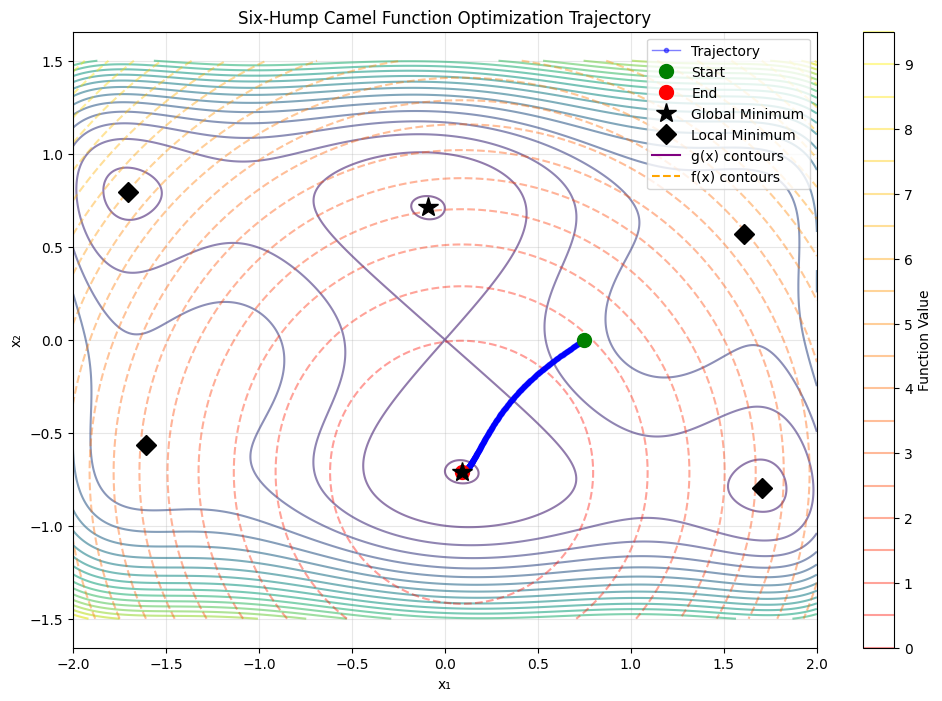

In [5]:
import matplotlib.pyplot as plt
# Create enhanced visualization
plt.figure(figsize=(12, 8))

# Create grid for contour plots
x1_range = np.linspace(-2, 2, 400)
x2_range = np.linspace(-1.5, 1.5, 400)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z_g = np.zeros_like(X1)  # for example_g
Z_f = np.zeros_like(X1)  # for example_f

# Calculate function values for contours
for i in range(len(x1_range)):
    for j in range(len(x2_range)):
        point = np.array([X1[j,i], X2[j,i]])
        Z_g[j,i] = example_g(point)
        Z_f[j,i] = example_f(point)

# Plot contours for both functions
plt.contour(X1, X2, Z_g, levels=20, cmap='viridis', alpha=0.6)  # example_g in viridis
plt.contour(X1, X2, Z_f, levels=20, cmap='autumn', alpha=0.4, linestyles='dashed')  # example_f in autumn with dashed lines

# Convert x_vec to numpy array if it isn't already
x_vec = np.array(x_vec)

# Plot trajectory
plt.plot(x_vec[:, 0], x_vec[:, 1], 'b.-', alpha=0.5, label='Trajectory', linewidth=1)

# Plot start and end points
plt.plot(x_vec[0, 0], x_vec[0, 1], 'go', label='Start', markersize=10)
plt.plot(x_vec[-1, 0], x_vec[-1, 1], 'ro', label='End', markersize=10)

# Global minima (marked with stars)
global_minima = [
    (0.08984201310031806, -0.7126564030207396),
    (-0.08984201310031806, 0.7126564030207396)
]
# Plot first point with label, rest without
plt.plot(global_minima[0][0], global_minima[0][1], 'k*', markersize=15, label='Global Minimum')
for x, y in global_minima[1:]:
    plt.plot(x, y, 'k*', markersize=15)

# Local minima (marked with diamonds)
local_minima = [
    (-1.703606714969981, 0.7960835686726251),
    (1.703606714969981, -0.7960835686726251),
    (-1.6071047529201974, -0.5686514548841314),
    (1.6071047529201974, 0.5686514548841314)
]
# Plot first point with label, rest without
plt.plot(local_minima[0][0], local_minima[0][1], 'kD', markersize=10, label='Local Minimum')
for x, y in local_minima[1:]:
    plt.plot(x, y, 'kD', markersize=10)

# Add contour labels to legend
plt.plot([], [], '-', color='purple', label='g(x) contours')
plt.plot([], [], '--', color='orange', label='f(x) contours')

# Customize plot
plt.grid(True, alpha=0.3)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Six-Hump Camel Function Optimization Trajectory')
plt.legend()
plt.colorbar(label='Function Value')

# Equal aspect ratio to prevent distortion
plt.axis('equal')

# Show the plot
plt.show()

In [ ]:
print(d_values)
print(grad_g_norm_values)

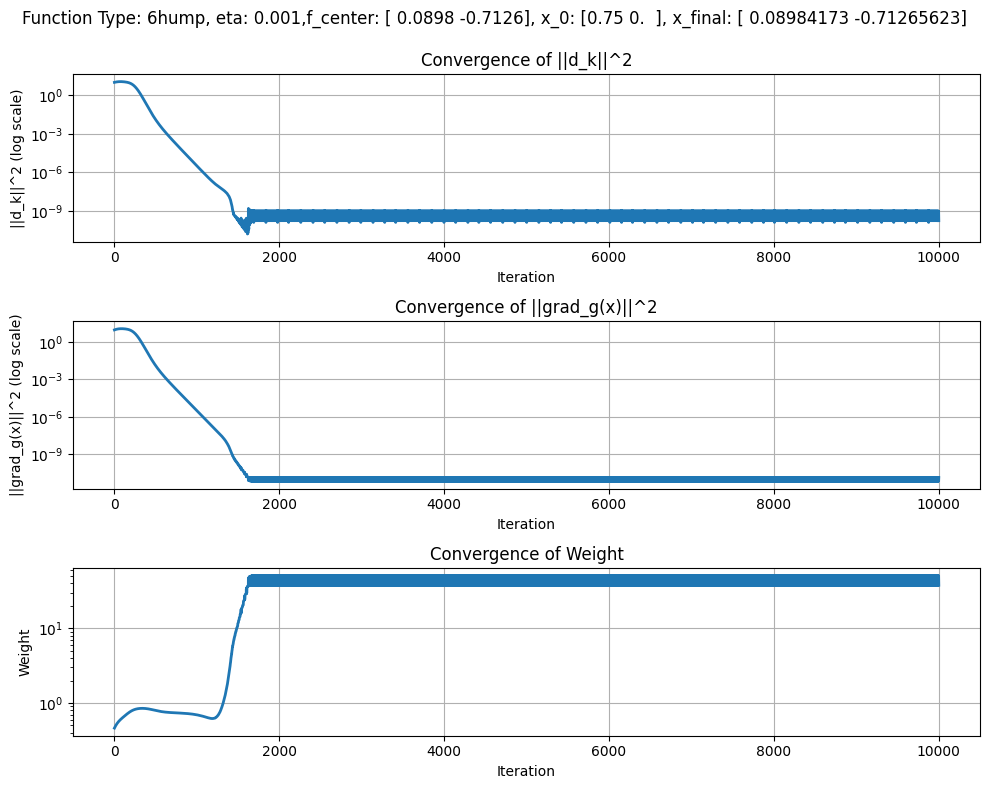

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3 ) = plt.subplots(3, 1, figsize=(10, 8))

# Plot f(x) in first subplot
ax1.semilogy(time_values, d_values, linewidth=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('||d_k||^2 (log scale)')
ax1.set_title('Convergence of ||d_k||^2')
ax1.grid(True)

# Plot g(x) in second subplot
ax2.semilogy(time_values, grad_g_norm_values, linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('||grad_g(x)||^2 (log scale)')
ax2.set_title('Convergence of ||grad_g(x)||^2')
ax2.grid(True)

ax3.semilogy(time_values, weight_vec, linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Weight')
ax3.set_title('Convergence of Weight')
ax3.grid(True)

# Add main title showing type and stepsize
plt.suptitle(f'Function Type: {g_type}, eta: {param["stepsize"]},f_center: {center}, x_0: {x0}, x_final: {x_final}', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for suptitle

# Show the plot
plt.show()

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # Use Agg backend
matplotlib.rcParams['text.usetex'] = False  # Disable LaTeX
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'  # Use a standard font

# Process data to set values after minimum to the minimum value
min_d = np.min(d_values)
min_grad = np.min(grad_g_norm_values)
d_values_modified = np.array([d if i <= np.argmin(d_values) else min_d for i, d in enumerate(d_values)])
grad_values_modified = np.array([g if i <= np.argmin(grad_g_norm_values) else min_grad for i, g in enumerate(grad_g_norm_values)])

# First plot: ||d_k||^2
plt.figure(figsize=(10, 4))
plt.semilogy(time_values, d_values_modified, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('||d_k||^2 (log scale)')
plt.title('Convergence of ||d_k||^2')
plt.grid(True)
plt.savefig('plot1.png', bbox_inches='tight', dpi=300)
plt.close()

# Second plot: ||grad_g(x)||^2
plt.figure(figsize=(10, 4))
plt.semilogy(time_values, grad_values_modified, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('||grad g(x)||^2 (log scale)')
plt.title('Convergence of ||grad g(x)||^2')
plt.grid(True)
plt.savefig('plot2.png', bbox_inches='tight', dpi=300)
plt.close()

# Third plot: Weight
plt.figure(figsize=(10, 4))
plt.semilogy(time_values, weight_vec, linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.title('Convergence of Weight')
plt.grid(True)
plt.savefig('plot3.png', bbox_inches='tight', dpi=300)
plt.close()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

In [15]:
t = np.linspace(0.0, 1.0, 100)
s = np.cos(4 * np.pi * t) + 2

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(t, s)

ax.set_xlabel(r'\textbf{time (s)}')
ax.set_ylabel('\\textit{Velocity (\N{DEGREE SIGN}/sec)}', fontsize=16)
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')

Text(0.5, 1.0, '\\TeX\\ is Number $\\displaystyle\\sum_{n=1}^\\infty\\frac{-e^{i\\pi}}{2^n}$!')

Error in callback <function _draw_all_if_interactive at 0x7e04e70a1c10> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found